In [15]:
!pip install catboost
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.7 MB/s eta 0:00:00


Импорты и загрузка данных

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


Загрузка и первичный анализ

In [17]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.info())
print(train.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL                  15000 non-null 

EDA (Анализ и визуализация)



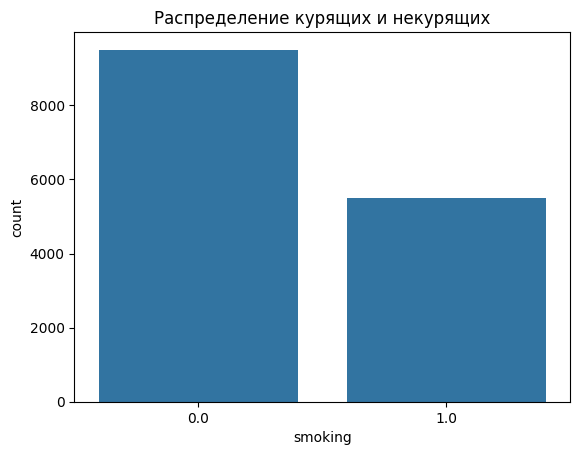

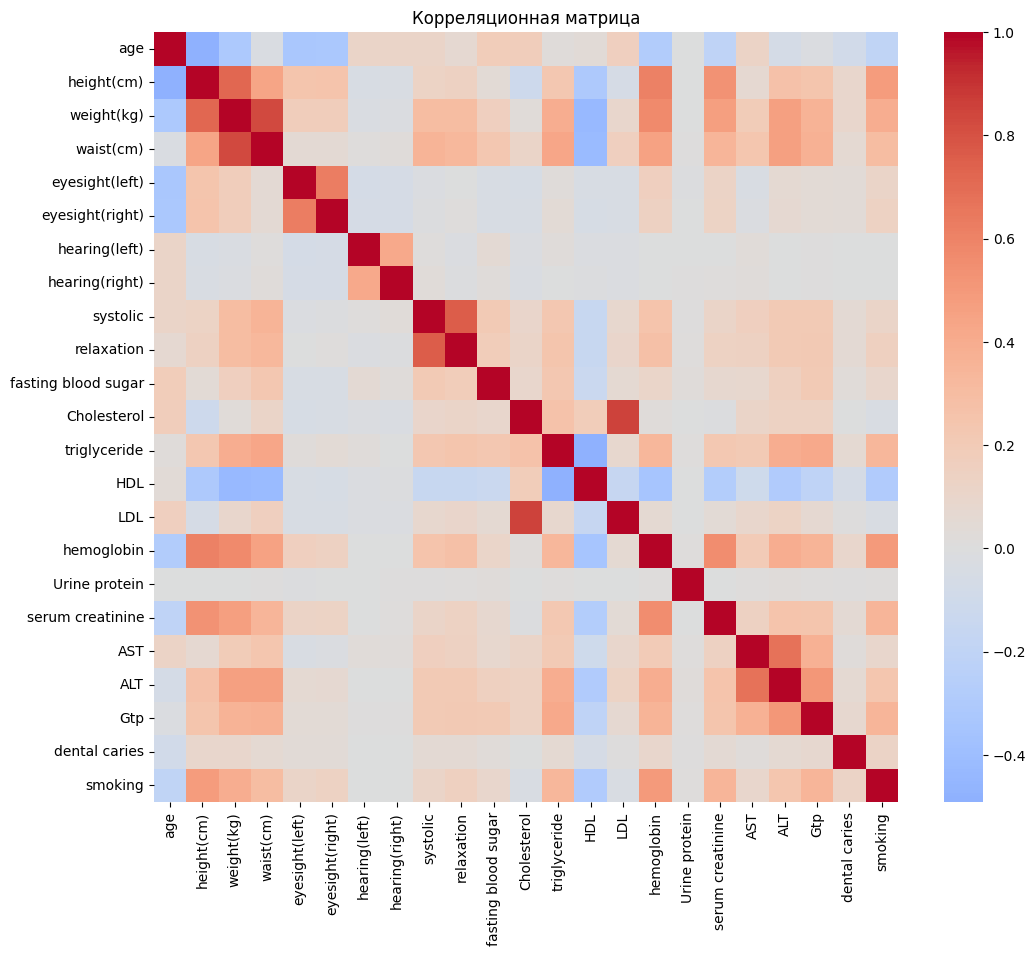

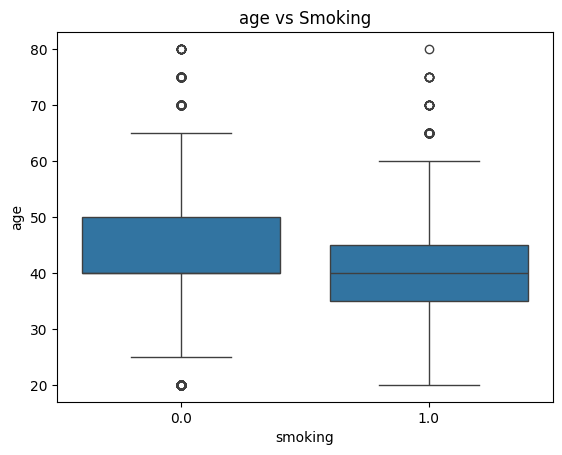

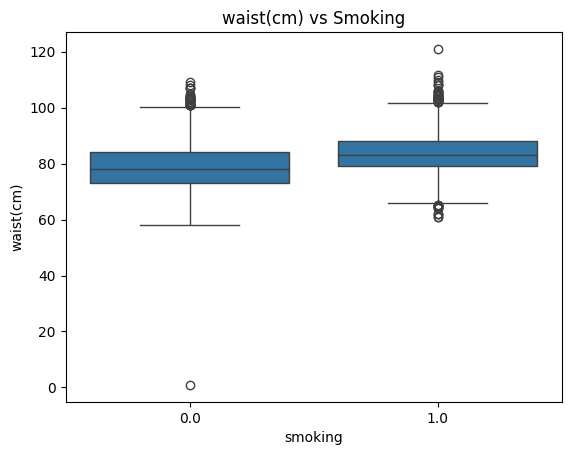

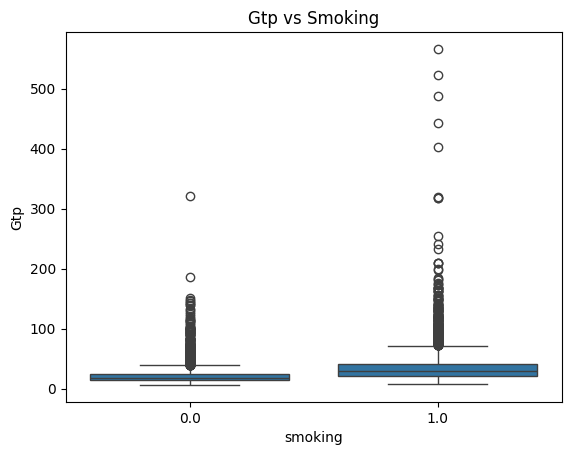

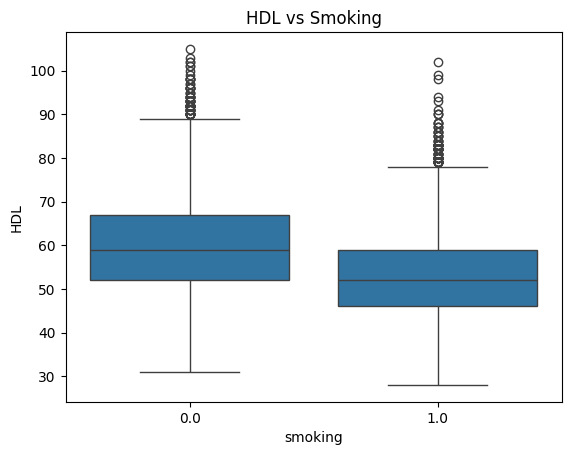

In [18]:
# Распределение целевой переменной
sns.countplot(x='smoking', data=train)
plt.title("Распределение курящих и некурящих")
plt.show()

# Матрица корреляций
corr = train.drop(columns=['id']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Корреляционная матрица")
plt.show()

# Boxplots
features = ['age', 'waist(cm)', 'Gtp', 'HDL']
for feat in features:
    sns.boxplot(x='smoking', y=feat, data=train)
    plt.title(f"{feat} vs Smoking")
    plt.show()


Подготовка данных

In [19]:
X = train.drop(columns=['id', 'smoking'])
y = train['smoking']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

X_test = scaler.transform(test.drop(columns=['id']))


Реализация кастомного бэггинга

In [20]:
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier

class CustomBaggingClassifier:
    def __init__(self, base_estimator, n_estimators=10):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.models = []

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            idx = np.random.choice(len(X), len(X), replace=True)
            model = clone(self.base_estimator)
            model.fit(X[idx], y.iloc[idx])
            self.models.append(model)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.round(predictions.mean(axis=0))


In [21]:
bag = CustomBaggingClassifier(DecisionTreeClassifier(), n_estimators=10)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred_bag))


Accuracy: 0.7656666666666667


Реализация кастомного градиентного бустинга

In [1]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

class CustomGradientBoosting:
    def __init__(self, n_estimators=10, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.init_pred = None

    def fit(self, X, y):
        self.init_pred = np.full(y.shape, np.log(y.mean() / (1 - y.mean())))
        residual = y - 1 / (1 + np.exp(-self.init_pred))

        for _ in range(self.n_estimators):
            model = DecisionTreeRegressor(max_depth=3)
            model.fit(X, residual)
            self.models.append(model)
            pred = model.predict(X)
            self.init_pred += self.learning_rate * pred
            residual = y - 1 / (1 + np.exp(-self.init_pred))

    def predict(self, X):
        pred = np.full(X.shape[0], np.log(0.5 / (1 - 0.5)))
        for model in self.models:
            pred += self.learning_rate * model.predict(X)
        return (1 / (1 + np.exp(-pred))) > 0.5


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

# Загрузка и подготовка данных
df = pd.read_csv("train.csv")
X = df.drop(columns=["id", "smoking"])
y = df["smoking"].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Обучение и предсказание
gb = CustomGradientBoosting(n_estimators=10, learning_rate=0.1)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)

# Оценка
print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_pred))




Accuracy: 0.744
ROC-AUC: 0.7864114832535885


Сравнение с библиотеками (sklearn, CatBoost, XGBoost, LightGBM)

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = {
    "Sklearn": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    print(f"{name}: ROC-AUC = {auc:.4f}")


Sklearn: ROC-AUC = 0.8804


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:07:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost: ROC-AUC = 0.8710
[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM: ROC-AUC = 0.8748
CatBoost: ROC-AUC = 0.8810


Подбор гиперпараметров с Optuna

In [27]:
import optuna

def objective(trial):
    clf = LGBMClassifier(
        num_leaves=trial.suggest_int('num_leaves', 10, 50),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        n_estimators=trial.suggest_int('n_estimators', 50, 300)
    )
    clf.fit(X_train, y_train)
    return roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print("Best parameters:", study.best_params)


[I 2025-05-23 09:08:06,894] A new study created in memory with name: no-name-67e4a87d-b02f-4b7c-9052-330dd45cd432
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:07,614] Trial 0 finished with value: 0.8683143540669856 and parameters: {'num_leaves': 37, 'learning_rate': 0.21143265612308745, 'n_estimators': 235}. Best is trial 0 with value: 0.8683143540669856.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:07,841] Trial 1 finished with value: 0.8799315789473683 and parameters: {'num_leaves': 11, 'learning_rate': 0.07521266135203428, 'n_estimators': 94}. Best is trial 1 with value

[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:08,409] Trial 2 finished with value: 0.875400956937799 and parameters: {'num_leaves': 50, 'learning_rate': 0.12230188800278856, 'n_estimators': 178}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:08,767] Trial 3 finished with value: 0.8702990430622008 and parameters: {'num_leaves': 32, 'learning_rate': 0.1969516837249757, 'n_estimators': 127}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:09,012] Trial 4 finished with value: 0.8783516746411484 and parameters: {'num_leaves': 11, 'learning_rate': 0.20360812850392088, 'n_estimators': 128}. Best is trial 1 with value

[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:09,281] Trial 5 finished with value: 0.8775277511961723 and parameters: {'num_leaves': 48, 'learning_rate': 0.1168623524744658, 'n_estimators': 54}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:09,691] Trial 6 finished with value: 0.873022966507177 and parameters: {'num_leaves': 36, 'learning_rate': 0.15325196879164846, 'n_estimators': 141}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:10,462] Trial 7 finished with value: 0.8740377990430622 and parameters: {'num_leaves': 42, 'learning_rate': 0.13430691568612788, 'n_estimators': 261}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:10,917] Trial 8 finished with value: 0.8721086124401913 and parameters: {'num_leaves': 17, 'learning_rate': 0.24241613315178245, 'n_estimators': 234}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:11,326] Trial 9 finished with value: 0.8769095693779904 and parameters: {'num_leaves': 18, 'learning_rate': 0.1324455569239964, 'n_estimators': 197}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:11,530] Trial 10 finished with value: 0.8713638755980861 and parameters: {'num_leaves': 24, 'learning_rate': 0.029598389654927976, 'n_estimators': 53}. Best is trial 1 with valu

[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:11,839] Trial 11 finished with value: 0.8787937799043062 and parameters: {'num_leaves': 10, 'learning_rate': 0.05461806323789566, 'n_estimators': 106}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:12,083] Trial 12 finished with value: 0.8752631578947369 and parameters: {'num_leaves': 10, 'learning_rate': 0.034456377084870475, 'n_estimators': 95}. Best is trial 1 with va

[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:12,383] Trial 13 finished with value: 0.8794464114832536 and parameters: {'num_leaves': 22, 'learning_rate': 0.06687186599435162, 'n_estimators': 92}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:12,665] Trial 14 finished with value: 0.8780746411483253 and parameters: {'num_leaves': 23, 'learning_rate': 0.07981718014829037, 'n_estimators': 84}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:13,073] Trial 15 finished with value: 0.8765043062200956 and parameters: {'num_leaves': 25, 'learning_rate': 0.07987677799901065, 'n_estimators': 153}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:13,317] Trial 16 finished with value: 0.8797775119617225 and parameters: {'num_leaves': 17, 'learning_rate': 0.0876715842305979, 'n_estimators': 78}. Best is trial 1 with valu

[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:13,546] Trial 17 finished with value: 0.8787014354066985 and parameters: {'num_leaves': 16, 'learning_rate': 0.09739321463696056, 'n_estimators': 75}. Best is trial 1 with value: 0.8799315789473683.


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:14,117] Trial 18 finished with value: 0.8673712918660288 and parameters: {'num_leaves': 15, 'learning_rate': 0.29229463271838535, 'n_estimators': 298}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:14,646] Trial 19 finished with value: 0.8750035885167463 and parameters: {'num_leaves': 28, 'learning_rate': 0.012870444136809073, 'n_estimators': 172}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:14,953] Trial 20 finished with value: 0.8753043062200956 and parameters: {'num_leaves': 20, 'learning_rate': 0.16704378235117248, 'n_estimators': 114}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:15,173] Trial 21 finished with value: 0.8793688995215311 and parameters: {'num_leaves': 14, 'learning_rate': 0.05790755128498659, 'n_estimators': 72}. Best is trial 1 with val

[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:15,468] Trial 22 finished with value: 0.8773698564593302 and parameters: {'num_leaves': 21, 'learning_rate': 0.0922503383842439, 'n_estimators': 98}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:15,853] Trial 23 finished with value: 0.8785291866028708 and parameters: {'num_leaves': 28, 'learning_rate': 0.06105215480412523, 'n_estimators': 70}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:16,293] Trial 24 finished with value: 0.878222966507177 and parameters: {'num_leaves': 14, 'learning_rate': 0.10133980024147098, 'n_estimators': 113}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:16,938] Trial 25 finished with value: 0.8791153110047846 and parameters: {'num_leaves': 20, 'learning_rate': 0.04352343546527265, 'n_estimators': 150}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:17,191] Trial 26 finished with value: 0.8793320574162679 and parameters: {'num_leaves': 13, 'learning_rate': 0.15725599117380196, 'n_estimators': 52}. Best is trial 1 with val

[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:17,627] Trial 27 finished with value: 0.8786851674641148 and parameters: {'num_leaves': 19, 'learning_rate': 0.08026294646661489, 'n_estimators': 90}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:18,238] Trial 28 finished with value: 0.8784856459330144 and parameters: {'num_leaves': 27, 'learning_rate': 0.06675883326503568, 'n_estimators': 119}. Best is trial 1 with value: 0.8799315789473683.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-23 09:08:18,773] Trial 29 finished with value: 0.8741775119617224 and parameters: {'num_leaves': 32, 'learning_rate': 0.10911980182152506, 'n_estimators': 172}. Best is trial 1 with value: 0.8799315789473683.


Best parameters: {'num_leaves': 11, 'learning_rate': 0.07521266135203428, 'n_estimators': 94}


Реализация и проверка метрик

In [28]:
def my_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def my_precision(y_true, y_pred):
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    return TP / (TP + FP)

def my_recall(y_true, y_pred):
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    return TP / (TP + FN)

def my_f1(y_true, y_pred):
    p = my_precision(y_true, y_pred)
    r = my_recall(y_true, y_pred)
    return 2 * p * r / (p + r)


Сравнение с sklearn:

In [29]:
y_pred_val = model.predict(X_val)
print("Accuracy:", my_accuracy(y_val, y_pred_val), accuracy_score(y_val, y_pred_val))
print("Precision:", my_precision(y_val, y_pred_val), precision_score(y_val, y_pred_val))
print("Recall:", my_recall(y_val, y_pred_val), recall_score(y_val, y_pred_val))
print("F1:", my_f1(y_val, y_pred_val), f1_score(y_val, y_pred_val))


Accuracy: 0.8003333333333333 0.8003333333333333
Precision: 0.7061728395061728 0.7061728395061728
Recall: 0.78 0.78
F1: 0.7412526997840173 0.7412526997840173
